# Assignment 3:

**Research question: "Build a recommendation system that recommend products each customer will purchase."**

**Members**:

- Nguyen Thi Quynh Giang - s386617
- Vo Gia Bao - s3823477
- Phan Ngoc Quang Anh - s3810148


<b>Methodologies Overview:</b>

<b>1. Collaborative Filtering RecSys based on RFM Analysis of purchase dataset of H&M <b>(transaction_train.csv)</b>:</b>

- This approach would purely consume the transaction_train.csv dataset to build User profile utilizing RFM technique.
- Data will be transformed accordingly to fit into pre-trained models provided by Surprise library.<br>

<b>2. Image-based content-based RecSys using 2 datasets: <b>articles.csv and article images:</b></b>

- The main dataset for this approach will be the images of articles, which will be the target to extract features from, using CNN ResNet50 model.
- articles.csv dataset will also be utilized, but more like for reference and mapping purposes for the images.
- We sampled approximately ~7300 articles and its images from the original dataset (which contains 105k records.)


# 0. Library import


In [ ]:
# content-based filtering approach unzip files
# !unzip downscaled_images_raw.zip
# !unzip downscaled_images_structure.zip
# !unzip ResNet_Children_feature_product_ids.npy.zip
# !unzip ResNet_Children_features.npy.zip
# !unzip ResNet_Divided_feature_product_ids.npy.zip
# !unzip ResNet_Divided_features.npy.zip
# !unzip ResNet_Ladieswear_feature_product_ids.npy
# !unzip ResNet_Ladieswear_features.npy.zip
# !unzip ResNet_Menswear_feature_product_ids.npy.zip
# !unzip ResNet_Menswear_features.npy.zip
# !unzip ResNet_Sport_feature_product_ids.npy.zip
# !unzip ResNet_Sport_features.npy.zip
# !unzip transactions_train.csv.zip
# !unzip articles.csv.zip

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from sklearn.metrics.pairwise import cosine_similarity
# collaborative filtering modeling
import pickle
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import cross_validate, train_test_split
from surprise.prediction_algorithms import SVD, NMF

# Image reprocessing and image extraction
import os
import cv2
import tensorflow as tf
import matplotlib.image as mpimg
from tensorflow import keras
from PIL import Image
from keras.layers import Embedding
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
# contant-based modeling imports
from sklearn.metrics import pairwise_distances

%matplotlib inline

theme = ["#AF0848", "#E90B60", "#CB2170", "#954E93",
         "#705D98", "#5573A8", "#398BBB", "#00BDE3"]
sns.set_palette('icefire', n_colors=None, desat=None, color_codes=False)


# I. Data Overview


For the 2 recommender systems approaches that we decided to build, we will use 3 datasets out of 4 dataset provided in the Kaggle competition (https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations).<br>

🛍️ **There are 2 metadata .csv files and 1 image dataset:**

- `images` - folder containing the photo of _almost_ all `article_ids`
- `articles.csv` - description features of all `article_ids` **(105,542 datapoints)**
- `transactions_train.csv` - file containing the `customer_id`, the article that was bought and at what price **(31,788,324 datapoints)**


## 1. Article data


Article data is detailed metadata for each article_id available for purchase


### 1.1. Import article dataset


In [ ]:
articles = pd.read_csv("articles.csv")
articles.head(10)


### 1.2. Article data Overview


In [191]:
articles.dtypes


article_id                       int64
product_code                     int64
prod_name                       object
product_type_no                  int64
product_type_name               object
product_group_name              object
graphical_appearance_no          int64
graphical_appearance_name       object
colour_group_code                int64
colour_group_name               object
perceived_colour_value_id        int64
perceived_colour_value_name     object
perceived_colour_master_id       int64
perceived_colour_master_name    object
department_no                    int64
department_name                 object
index_code                      object
index_name                      object
index_group_no                   int64
index_group_name                object
section_no                       int64
section_name                    object
garment_group_no                 int64
garment_group_name              object
detail_desc                     object
dtype: object

<!-- <style>
ul {
  list-style-type: none;
  padding: 0;
  margin: 0;
}

li {
  font-family: Arial, sans-serif;
  font-size: 16px;
  padding: 10px;
  margin-bottom: 5px;
  background-color: #f9f9f9;
  border-radius: 5px;
}
</style> -->

<ul>
  <li>article_id: an integer data type, which serves as a unique identifier for each article.</li>
  <li>product_code: an integer data type, which is used to represent the code of a product.</li>
  <li>prod_name: an object data type, which is used to store the name of a product.</li>
  <li>product_type_no: an integer data type, which is used to represent the group of product_code.</li>
  <li>product_type_name: an object data type, which is used to store the name of the product group.</li>
  <li>product_group_name: an object data type, which is used to store the name of the product group.</li>
  <li>graphical_appearance_no: an integer data type, which is used to represent the group of graphics.</li>
  <li>graphical_appearance_name: an object data type, which is used to store the name of the graphic group.</li>
  <li>colour_group_code: an integer data type, which is used to represent the group of colors.</li>
  <li>colour_group_name: an object data type, which is used to store the name of the color group.</li>
  <li>perceived_colour_value_id: an integer data type, which is used to represent additional information about a color.</li>
  <li>perceived_colour_value_name: an object data type, which is used to store the name of color information.</li>
  <li>perceived_colour_master_id: an integer data type, which is used to represent the master information about a color.</li>
  <li>perceived_colour_master_name: an object data type, which is used to store the name of master color information.</li>
  <li>department_no: an integer data type, which is used to represent the department.</li>
  <li>department_name: an object data type, which is used to store the name of the department.</li>
  <li>index_code: an object data type, which is used to represent the code of index.</li>
  <li>index_name: an object data type, which is used to store the name of the index.</li>
  <li>index_group_no: an integer data type, which is used to represent the group of the index.</li>
  <li>index_group_name: an object data type, which is used to store the name of the index group.</li>
  <li>section_no: an integer data type, which is used to represent the section of data.</li>
  <li>section_name: an object data type, which is used to store the name of the section.</li>
  <li>garment_group_no: an integer data type, which is used to represent the group of the garment.</li>
  <li>garment_group_name: an object data type, which is used to store the name of the garment group.</li>
  <li>detail_desc: an object data type, which is used to store detailed information about the data.</li>
</ul>


#### 1.3. Data sampling method:


In [ ]:
articles.shape


Taking a look at the <b>article images</b> folder structure from Kaggle (https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/data), we can see that the images are grouped into sub-folders whose name is the first 3 characters of the <b>article_id</b> and the image name is the <b>article_id</b>.
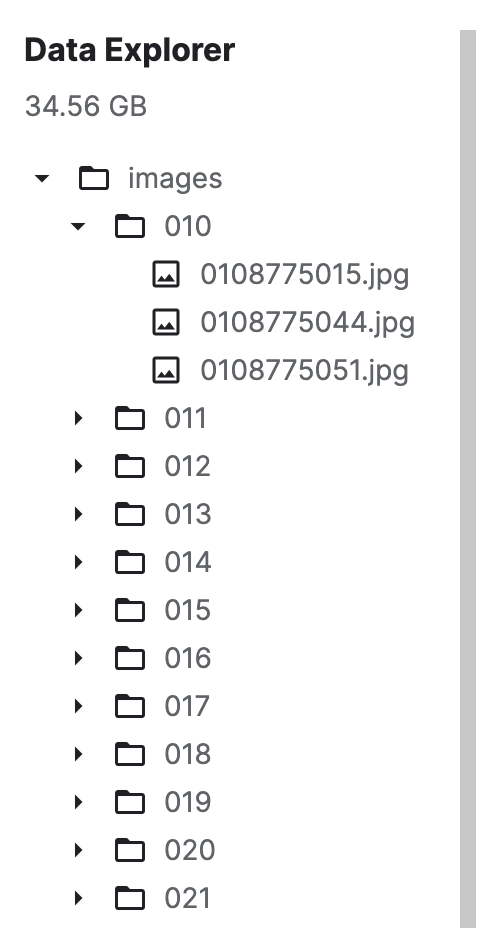


Since the original article data contains over 105k samples, we could not use this dataset for modeling as we do not have enough computing resources. The way we approach sampling article data that will also match the articles images is to get a set of consecutive records using column article_id. At the same time we will also select the folders of images respective to the range of <b>article_id</b>.

Here we decided to select articles sameple in range 290000000 -> 520000000. Then the images folders selected will be from subfolder named 029 to subfolder named 051.


In [ ]:
small_articles_df = articles[(articles['article_id'] >= 290000000) & (
    articles['article_id'] < 520000000)]


## 2. Transaction Dataset

### 2.1. Import Dataset


In [ ]:
transactions = pd.read_csv("transactions_train.csv")
transactions.head()


### 2.2 Transaction Dataset overview


In [ ]:
transactions.dtypes


<ul>
  <li>The dataset includes the following variables and their data types:</li>
    <ul>
      <li>t_dat, a variable of type object capturing the transaction date</li>
      <li>customer_id, a unique identifier of type object</li>
      <li>article_id, a unique identifier of type integer</li>
      <li>price, the monetary value associated with the transaction of type float</li>
      <li>sales_channel_id, a categorical variable identifying the sales channel involved in the transaction, taking on integer values.</li>
    </ul>
</ul>


From the provided dataset, we need to group the customer by "customer_id" then find the top 50 customers who spent most to apply the RFM analysis in the future.


In [ ]:
top_customer = transactions.groupby('customer_id').count(
).sort_values(by='price', ascending=False)['price']
top_customer[0:50]


# II. Data preparation


## 1. Article Dataset

#### 1.1. Check duplicate rows

In [ ]:
# check duplicates
small_articles_df.duplicated().any()


The dataset does not contain any duplicated rows.


### 1.2. Check article with no images


In [ ]:
# Set the input directory
input_dir = 'downscaled_images_raw/'

# # Get a list of the images in the input directory
image_folders = os.listdir(input_dir)
image_names = []

# # Iterate over the images
for folder in image_folders:
    # Load the image
    image_filenames = os.listdir(input_dir+folder)
    for filename in image_filenames:
        image_names.append(int(filename[0:10]))

print("Number of unique images: " + str(len(image_names)))
print("Number of unique article ids: " + str(small_articles_df.shape[0]))


<p>There is an inconsistent between the number of articles and the number of images even though they are sampled in groups. To be specific, number of images are <b style="color: #CB1C8D">81 item less</b> than the row count of article.csv. This implies that some are products in <b style="color: #CB1C8D">article.csv</b> do not have images associated with them.</p>

We will drop these records as to some extent, they are rows with NaN values.


In [ ]:
# get a list of article ids in dataframe
ids = small_articles_df["article_id"].to_list()

article_without_images = []

for id in ids:
    if (id not in image_names):
        article_without_images.append(id)

print(article_without_images)


In [ ]:
small_articles_df = small_articles_df[~small_articles_df["article_id"].isin(
    article_without_images)]
small_articles_df.shape


The number of samples and images are now equal to each other.


### 1.3. Values rename

Since the column **index_group_name** of this dataset will be used later on for metadata-based image grouping, we will rename some values to make it more convenient for that task.

In [ ]:
small_articles_df['index_group_name'].replace("Children/Baby", "Children", inplace=True)

## 2. Transaction Dataset:


### 2.1. Outliers detection and removal:

We need explore the distribution of price and the presence of outliers in the transactions dataset.


In [ ]:
f, ax = plt.subplots(figsize=(10, 5))


def plot_boxplots(col, df, param_axis):
    sns.boxplot(x=col, data=df, ax=param_axis)
    param_axis.set_xlabel(param_axis.get_xlabel(), fontsize=12)
    param_axis.tick_params(axis='both', which='major', labelsize=13)
    param_axis.set_title('Boxplot for ' + col, fontsize=14)
    plt.ticklabel_format(style='plain', axis='x')


plot_boxplots('price', transactions, ax)


# III. Data exploration:


## 1. Article Dataset:

#### 1.3.1 Categorical features


We have unique values of categorical columns as the following:


In [ ]:
for col in articles.columns:
    if not 'no' in col and not 'code' in col and not 'id' in col:
        unique_number = articles[col].nunique()
        print(f'number of unique {col}: {unique_number}')


#### 1.3.2 Key features

We select garment_group_name and index_group_name as these two features were chosen for analysis because they encapsulate a distinct separation of the articles into distinct categories


In [ ]:
group_counts = articles['garment_group_name'].value_counts()
description_counts = articles['index_group_name'].value_counts()

plt.barh(group_counts.index, group_counts.values)
plt.title('garment_group_name')
plt.xlabel('count')


In [ ]:
plt.barh(description_counts.index, description_counts.values)
plt.title('index_group_name (description)')
plt.xlabel('count')


In [ ]:
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=articles, y='garment_group_name',
                  hue='index_group_name', multiple="stack")
plt.title("Distribution articles by index_name (description) and garment_group_name")
plt.legend(title='Group Name', labels=[
           'Ladieswear', 'Baby/Children', 'Menswear', 'Sport', 'Divided'])
ax.set_xlabel('count by garment_group_name')
ax.set_ylabel('garment group')


We have a quantitative analysis of the distribution of articles was conducted by utilizing garment_group_name and index_group_name as categorical variables, providing insights into the frequency of occurrence for each group


In [ ]:
garment_index_count = articles.groupby(
    ['garment_group_name', 'index_group_name']).count()['article_id']
for i in range(len(garment_index_count)):
    print(f'{garment_index_count.index[i]}:{garment_index_count[i]}')


A quantitative analysis of the distribution of articles was conducted by utilizing index_group_name and index_name as categorical variables, providing insights into the frequency of occurrence for each group and subgroup respectivel.


In [ ]:
articles.groupby(['index_group_name', 'index_name']).count()['article_id']


## 2. Transactions dataset


#### 2.1. Highly Purchased Articles:


Top 10 most-buy articles


In [ ]:
purchases_counts = transactions['article_id'].value_counts().reset_index()
purchases_counts.columns = ['article_id', 'purchases']
purchases_counts.head(10)


In [ ]:
sns.barplot(x = 'article_id',
            y = 'purchases',
            data = purchases_counts.head(10),
            palette=theme)
plt.xticks(rotation=90)
plt.show()

In [ ]:
category = []
for id in set(purchases_counts["article_id"].head(100)):
    category.append(articles[articles['article_id']== id]["index_group_name"].values[0])

category_df= pd.DataFrame()
category_df["category"] = category
category_df.value_counts()

<b style="color: #AF0848 ">Observation:</b> Among the top 100 most-buy products, 92% of them have index_group_name of Ladieswear and Divided. More specifically, Ladieswear are the most popular ones as it occupies 70% of the most popular products.

#### 2.2. Top Customer By Purchases:

In [ ]:
customer_purchase_count = transactions['customer_id'].value_counts().reset_index()
customer_purchase_count.columns  = ['customer_id', 'items_purchased']

In [ ]:
sns.barplot(x = 'customer_id',
            y = 'items_purchased',
            data = customer_purchase_count.head(20))
plt.xticks(rotation=90)
plt.show()

<b style="color: #AF0848 ">Observation:</b> The top customer bought as many as >1750 purchases.

## 3. Images

Example of the most expensive product images and their descreption.

In [ ]:
left_join_transaction = transactions.merge(small_articles_df, on='article_id', how='left')

left_join_transaction.dropna(inplace=True)
# max_price_ids = transactions[transactions.t_dat==transactions.t_dat.max()].sort_values('price', ascending=False).iloc[:5][['article_id', 'price']]
# min_price_ids = transactions[transactions.t_dat==transactions.t_dat.min()].sort_values('price', ascending=True).iloc[:5][['article_id', 'price']]

In [ ]:
f, ax = plt.subplots(1, 5, figsize=(20,10))
i = 0

max_price_ids = left_join_transaction[left_join_transaction.t_dat==left_join_transaction.t_dat.max()].sort_values('price', ascending=False).iloc[:5][['article_id', 'price']]
min_price_ids = left_join_transaction[left_join_transaction.t_dat==left_join_transaction.t_dat.min()].sort_values('price', ascending=True).iloc[:5][['article_id', 'price']]


for _, data in max_price_ids.iterrows():
    desc = small_articles_df[small_articles_df['article_id'] == data['article_id']]['detail_desc'].iloc[0]
    desc_list = desc.split(' ')
    for j, elem in enumerate(desc_list):
        if j > 0 and j % 5 == 0:
            desc_list[j] = desc_list[j] + '\n'
    desc = ' '.join(desc_list)
    img = mpimg.imread(f'downscaled_images_raw/0{str(data.article_id)[:2]}/0{int(data.article_id)}.jpg')
    ax[i].imshow(img)
    ax[i].set_title(f'price: {data.price:.2f}')
    ax[i].set_xticks([], [])
    ax[i].set_yticks([], [])
    ax[i].grid(False)
    ax[i].set_xlabel(desc, fontsize=10)
    i += 1
plt.show()

Example of the cheapeast product images and their descreption.

In [ ]:
f, ax = plt.subplots(1, 5, figsize=(20,10))
i = 0

for _, data in min_price_ids.iterrows():
    desc = small_articles_df[small_articles_df['article_id'] == data['article_id']]['detail_desc'].iloc[0]
    desc_list = desc.split(' ')
    for j, elem in enumerate(desc_list):
        if j > 0 and j % 5 == 0:
            desc_list[j] = desc_list[j] + '\n'
    desc = ' '.join(desc_list)
    img = mpimg.imread(f'downscaled_images_raw/0{str(data.article_id)[:2]}/0{int(data.article_id)}.jpg')
    ax[i].imshow(img)
    ax[i].set_title(f'price: {data.price:.2f}')
    ax[i].set_xticks([], [])
    ax[i].set_yticks([], [])
    ax[i].grid(False)
    ax[i].set_xlabel(desc, fontsize=10)
    i += 1
plt.show()

# IV. Building Recommendation System


## 1. Item-user Collaborative Filtering based on RFM customer profile

### 1.1. Methodology:

### 1.2. Data Preprocessing:

#### 1.2.1 Transaction data

The transformation of the variable t_dat to the variable InvoiceDate with the appropriate format for time series analysis to facilitate further processing. In addition, duplicate records were removed as they are not necessary


In [ ]:
transactions['InvoiceDate'] = pd.to_datetime(
    transactions['t_dat'], format='%Y-%m-%d')
transactions = transactions[["InvoiceDate", "customer_id",
                             "article_id", "price", "sales_channel_id"]].drop_duplicates()
transactions.head().T


We have an analysis of the transaction dataset was conducted to identify the distinct customers who have made purchases.


In [ ]:
unique_customers = transactions['customer_id'].unique().tolist()
len(unique_customers)


The number of unique customers who made purchases is 1362281, while the total number of customers in the dataset is 1371980.


In [ ]:
# The unique products or article_id
unique_articles = transactions['article_id'].unique().tolist()
len(unique_articles)


The number of unique products that were the subject of transactions is 104547, in comparison to the total number of products in the dataset which is 105542.


#### 1.2.2 RFM Analysis


<b>Explain:</b> RFM (Recency, Frequency, Monetary) analysis and collaborative filtering are two different techniques that are often used in different scenarios but can be combined for an even better results in some cases, specifically in recommendations systems. For example, using RFM analysis, businesses can identify the most valuable customers, and then use collaborative filtering to recommend products to those customers that similar customers have also purchased.


In [ ]:
start_date = datetime.datetime(2020, 3, 1)

# Filter transactions by date
transactions["t_dat"] = pd.to_datetime(transactions["InvoiceDate"])
transactions = transactions.loc[transactions["t_dat"] >= start_date]

# analysis_date = max(transactions['InvoiceDate']) + dt.timedelta(days= 1)
analysis_date = datetime.datetime(2020, 9, 23)

transactions['date'] = transactions['InvoiceDate']
(analysis_date - transactions['InvoiceDate'].max()).days

rfm = transactions.groupby('customer_id').agg({
    'InvoiceDate': lambda x: (analysis_date - x.max()).days,
    'date': 'count',
    'price': 'sum'})

rfm.head().T


From the above RFM analysis, we could build a user-profile as follow


In [ ]:
rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm = rfm[rfm["Monetary"] > 0]
# the highest rank receives a score of 5 and the lowest receives a score of 1
rfm["recency_score"] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])

# the highest rank receives a score of 5 and the lowest receives a score of 1
rfm["frequency_score"] = pd.qcut(rfm["Frequency"].rank(
    method="first"), 5, labels=[1, 2, 3, 4, 5])

# the highest rank receives a score of 5 and the lowest receives a score of 1
rfm["monetary_score"] = pd.qcut(rfm["Monetary"], 5, labels=[1, 2, 3, 4, 5])

rfm.head().T


In [ ]:
# calculates the overall RFM score based on frequency and recency
rfm["RFM_SCORE"] = (rfm["recency_score"].astype(
    str) + rfm["frequency_score"].astype(str))


In [ ]:
# define the customer segments
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}
rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)
rfm.head().T


In [ ]:
# The description of the segments
rfm[["segment", "Recency", "Frequency", "Monetary"]].groupby(
    "segment").agg(["mean", "count", "max"]).round()


#### 1.2.3. Creating Item-based data for Collaborative Filtering


In [ ]:
rfm = rfm.reset_index()

In [ ]:
transactions.head(10).T

In [ ]:
rfm.head(10).T

Merge RFM user profile dataset with transaction dataset.

In [ ]:
# Merge inner joion rfm với transactions by customer_id
transactions = pd.merge(
    transactions, rfm[["customer_id", "segment"]], how='inner', on='customer_id')
transactions.head().T


Take only potential customer that will be influenced by the collaborative-filtering recommender system

In [ ]:
# From the separated segments, only take potential customers
training_segment = ['champions', 'potential_loyalists', 'new_customers','promising','loyal_customers']
transactions = transactions[transactions['segment'].isin(training_segment)]
transactions

After filtering, we do not need customer segment anymore

In [ ]:
# Drop unused customer segments
transactions = transactions.drop('segment', axis=1)
transactions


Limit to recent data -> makes sense

In [ ]:
start_date = datetime.datetime(2020, 9, 1)
# Take some valuable transaction after 01/09/2020
transactions["t_dat"] = transactions["InvoiceDate"]
transactions = transactions.loc[transactions["InvoiceDate"] >= start_date]
transactions

Get articles id that are bought over 10 times

In [ ]:
# Count the number of times each article was bought
article_bought_count = transactions[['article_id', 'InvoiceDate']].groupby(
    'article_id').count().reset_index().rename(columns={'InvoiceDate': 'count'})


# Get the article IDs for articles that were bought more than 10 times
most_bought_articles = article_bought_count[article_bought_count['count']
                                            > 10]['article_id'].values

# Filter the transactions dataframe to include only the most bought articles
transactions = transactions[transactions['article_id'].isin(
    most_bought_articles)]

# Add a new "bought" column to the transactions dataframe with a value of 1 for each row
transactions["bought"] = 1
transactions.head().T


In [ ]:
# count the article sales times
article_bought_count = transactions[['article_id', 'InvoiceDate']].groupby(
    'article_id').count().reset_index().rename(columns={'InvoiceDate': 'count'})
article_bought_count

summary the above code block, could be removed

In [ ]:
# select the articles that have been bought than 10 times
most_bought_articles = article_bought_count[article_bought_count['count']
                                            > 10]['article_id'].values
most_bought_articles


In [ ]:
# From the defined best-sales articles, we could take the relevant transactions
transactions = transactions[transactions['article_id'].isin(
    most_bought_articles)]
transactions["bought"] = 1
transactions.head().T


Create negative samples for classification

In [ ]:
# create negative sample
np.random.seed(11)
negative_samples = pd.DataFrame({
    'article_id': np.random.choice(transactions.article_id.unique()),
    'customer_id': np.random.choice(transactions.customer_id.unique()),
    'bought': np.zeros(transactions.shape[0])
})
negative_samples.head().T


In [ ]:
# Concat the possitive and negative samples
transactions = pd.concat([transactions, negative_samples])
transactions.head().T


Save cleaned data to a file.

In [ ]:
# save the handled transaction data
compression_opts = dict(method='zip', archive_name='cf_dataset.zip')
transactions.to_csv('cf_dataset.zip', index=False,
                    compression=compression_opts)


### 1.3. Item-based collaborative approach modeling


In [ ]:
transactions = pd.read_csv('cf_dataset.zip')
transactions.head().T


In [ ]:
reader = Reader(rating_scale=(0, 1))
customer_data = Dataset.load_from_df(
    transactions[['customer_id', 'article_id', 'bought']], reader)

In [ ]:
# split to train and test set
trainset, testset = train_test_split(
    customer_data, test_size=0.2, random_state=42)
trainset


#### 1.3.1 Singular Value Decomposition (SVD)


In [ ]:
svd_model = SVD(n_factors=10, n_epochs=50)

svd_model.fit(trainset)

svd_predictions = svd_model.test(testset)

svd_rmse = accuracy.rmse(svd_predictions)
svd_mse = accuracy.mse(svd_predictions)


try to predict some customers


In [ ]:
test_customers = [1, 5, 10, 20, 29]
for customer in test_customers:
    prediction = svd_model.predict(
        transactions['customer_id'][customer], transactions['article_id'][customer])
    print(prediction)


#### 1.3.2 Non-Negative Matrix Factorization (NMF)


In [ ]:
nmf_model = NMF(n_factors=10, n_epochs=100)

nmf_model.fit(trainset)

nmf_predictions = nmf_model.test(testset)

nmf_rmse = accuracy.rmse(nmf_predictions)
nmf_rse = accuracy.mse(nmf_predictions)
nmf_mae = accuracy.mae(nmf_predictions)


try to predict some customers


In [ ]:
test_customers = [1, 5, 10, 20, 29]
for customer in test_customers:
    prediction = nmf_model.predict(
        transactions['customer_id'][customer], transactions['article_id'][customer])
    print(prediction)


### 1.4. Final Model


We select the SVD as our final model since the RMSE and RSE is lower than those numbers of NMF model.
We will return the full trainset.


In [ ]:
trainset_full = customer_data.build_full_trainset()


Then we will build a full model using the full trainset


In [ ]:
final_model = SVD(n_factors=10, n_epochs=50)
final_model.fit(trainset_full)


In [ ]:
pickle.dump(final_model, open('collaborative_model.sav', 'wb'))
final_model = pickle.load(open('collaborative_model.sav', 'rb'))


### 1.5. Recommendation system using item-based Collaborative filtering approach


Reload the transaction and article dataset


In [ ]:
transactions = pd.read_csv('cf_dataset.zip')
meta_articles = pd.read_csv('articles.csv', index_col='article_id')
transactions.head().T


In [ ]:
df_customer = transactions.set_index('customer_id')
# drop some unused columns
df_customer.drop(columns=['InvoiceDate', 'price',
                 'sales_channel_id', 't_dat', 'date', 'bought'], inplace=True)
df_customer.head()


In [ ]:
df_customer = transactions.set_index('customer_id')
df_customer.drop(columns=['InvoiceDate', 'price', 'sales_channel_id',
                 't_dat', 'date', 'bought'], inplace=True)  # Bỏ vì không cần thiết nữa
df_customer


We have a function to recommend the article_id to customers


In [ ]:
def customer_article_recommend(user, n_recs):

    # article listing
    have_bought = list(df_customer.loc[user]['article_id'])

    # make new df to ensure data intergrity
    not_bought = meta_articles.copy()

    not_bought.drop(have_bought, inplace=True)
    not_bought.reset_index(inplace=True)

    # predict rating of each article
    not_bought['est_purchase'] = not_bought['article_id'].apply(
        lambda x: final_model.predict(user, x).est)

    # Sort based on ratings
    not_bought.sort_values(by='est_purchase', ascending=False, inplace=True)

    # rename the column title
    not_bought.rename(columns={'prod_name': 'Product Name', 'product_type_name': 'Product Type Name', 'product_group_name': 'Product Group Name',
                               'index_group_name': 'Index Group Name', 'garment_group_name': 'Garment Group Name'}, inplace=True)
    not_bought = not_bought[['article_id', 'Product Name', 'Product Type Name',
                             'Product Group Name', 'Index Group Name', 'Garment Group Name']]

    # take the top 100
    not_bought.iloc[:100, :]
    not_bought = not_bought.sample(frac=1).reset_index(drop=True)

    return not_bought.head(n_recs)


In [ ]:
customer = '002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc'
items = customer_article_recommend(customer, 20)
items


## 2. Content-based Image-based Filtering approach




### 2.1. Methodology:

### 2.2. Data Pre-processing


#### 2.2.1. Downscale images and carry out metadata-based image grouping


In [ ]:
# # Set the input directory
# input_dir = 'downscaled_images_raw/'

# # Set the output directory
# output_dir = 'downscaled_images_structure/'

# # # Get a list of the images in the input directory
# image_folders = os.listdir(input_dir)

# # # Iterate over the images
# for folder in image_folders:
#     image_filenames = os.listdir(input_dir+folder)
#     for filename in image_filenames:
#         # Load the image
#         image = cv2.imread(input_dir + folder + "/" + filename)

#         folder_name = small_articles_df[small_articles_df['article_id'] == int(
#             filename[0:10])]["index_group_name"].values[0]
#         # Downscale the image using linear interpolation
#         downscaled_image = cv2.resize(
#             image, (224, 224), interpolation=cv2.INTER_LINEAR)
#         # Save the downscaled image to a file
#         cv2.imwrite(output_dir+folder_name+"/" +
#                     "Images/" + filename, downscaled_image)


### 2.3. Feature Engineering


In [ ]:
# index_group_name values
train_data_groups = ["Children", "Divided",
                     "Ladieswear", "Menswear", "Sport"]

epochs = 50
batch_size = 1


def extract_features(group, model, model_name):
    Itemcodes = []
    datagen = ImageDataGenerator(rescale=1. / 255)
    
    dir_path = "downscaled_images_structure/"+group+'/'
    # image data augmentation
    generator = datagen.flow_from_directory(
        dir_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    for i in generator.filenames:
        Itemcodes.append(i[(i.find("/")+1):i.find(".")])
    extracted_features = model.predict(
        generator, len(generator.filenames) // batch_size)

    extracted_features = extracted_features.reshape(
        (len(generator.filenames), -1))

    np.save(open('./ResNet_{group}_{model_name}_features.npy'.format(
        group=group, model_name=model_name), 'wb'), extracted_features)
    np.save(open('./ResNet_{group}_{model_name}_feature_product_ids.npy'.format(
        group=group, model_name=model_name), 'wb'),
            np.array(Itemcodes))


#### 2.3.1. Resnet50 For Feature Extraction

In [ ]:
# resnet_model = applications.ResNet50(
#         include_top=False, weights='imagenet')
  
# for image_group in train_data_groups:
#     extract_features(image_group,resnet_model, "ResNet50" )

In [ ]:
# import ssl


# ssl._create_default_https_context = ssl._create_unverified_context
# resnet_model = applications.VGG16(
#         include_top=False, weights='imagenet')
  
# for image_group in train_data_groups:
#     extract_features(image_group,resnet_model, "VGG16" )


#### 2.3.2. Load the feature separators


In [ ]:
# ResNet50 generated features
children_extracted_features = np.load('ResNet_Children_features.npy')
children_Productids = np.load('ResNet_Children_feature_product_ids.npy')
divided_extracted_features = np.load(
    './ResNet_Divided_features.npy')
divided_Productids = np.load('./ResNet_Divided_feature_product_ids.npy')
menswear_extracted_features = np.load(
    './ResNet_Menswear_features.npy')
menswear_Productids = np.load(
    './ResNet_Menswear_feature_product_ids.npy')
ladieswear_extracted_features = np.load(
    './ResNet_Ladieswear_features.npy')
ladieswear_Productids = np.load(
    './ResNet_Ladieswear_feature_product_ids.npy')
sport_extracted_features = np.load('./ResNet_Sport_features.npy')
sport_Productids = np.load(
    './ResNet_Sport_feature_product_ids.npy')

VGG16_children_extracted_features = np.load('ResNet_Children_VGG16_features.npy')
VGG16_children_Productids = np.load('ResNet_Children_VGG16_feature_product_ids.npy')
VGG16_divided_extracted_features = np.load(
    './ResNet_Divided_VGG16_features.npy')
VGG16_divided_Productids = np.load('./ResNet_Divided_VGG16_feature_product_ids.npy')
VGG16_menswear_extracted_features = np.load(
    './ResNet_Menswear_VGG16_features.npy')
VGG16_menswear_Productids = np.load(
    './ResNet_Menswear_VGG16_feature_product_ids.npy')
VGG16_ladieswear_extracted_features = np.load(
    './ResNet_Ladieswear_VGG16_features.npy')
VGG16_ladieswear_Productids = np.load(
    './ResNet_Ladieswear_VGG16_feature_product_ids.npy')
VGG16_sport_extracted_features = np.load('./ResNet_Sport_VGG16_features.npy')
VGG16_sport_Productids = np.load(
    './ResNet_Sport_VGG16_feature_product_ids.npy')

#### 2.3.3. Load Features


In [ ]:
def get_extracted_features_resnet(product_id):
    if (small_articles_df[small_articles_df['article_id'] == int(product_id)].empty):
        print(
            small_articles_df[small_articles_df['article_id'] == int(product_id)])
        return "No item matched input Id"
    elif (small_articles_df[small_articles_df['article_id'] == int(product_id)]['index_group_name'].values[0] == "Children"):
        extracted_features = children_extracted_features
        article_ids = children_Productids
    elif (small_articles_df[small_articles_df['article_id'] == int(product_id)]['index_group_name'].values[0] == "Divided"):
        extracted_features = divided_extracted_features
        Prarticle_idsoductids = divided_Productids
    elif (small_articles_df[small_articles_df['article_id'] == int(product_id)]['index_group_name'].values[0] == "Menswear"):
        extracted_features = menswear_extracted_features
        article_ids = menswear_Productids
    elif (small_articles_df[small_articles_df['article_id'] == int(product_id)]['index_group_name'].values[0] == "Ladieswear"):
        extracted_features = ladieswear_extracted_features
        article_ids = ladieswear_Productids
    else:
        extracted_features = sport_extracted_features
        article_ids = sport_Productids
    return extracted_features, article_ids

def get_extracted_features_VGG16(product_id):
    if (small_articles_df[small_articles_df['article_id'] == int(product_id)].empty):
        print(
            small_articles_df[small_articles_df['article_id'] == int(product_id)])
        return "No item matched input Id"
    elif (small_articles_df[small_articles_df['article_id'] == int(product_id)]['index_group_name'].values[0] == "Children"):
        extracted_features = VGG16_children_extracted_features
        article_ids = VGG16_children_Productids
    elif (small_articles_df[small_articles_df['article_id'] == int(product_id)]['index_group_name'].values[0] == "Divided"):
        extracted_features = VGG16_divided_extracted_features
        article_ids = VGG16_divided_Productids
    elif (small_articles_df[small_articles_df['article_id'] == int(product_id)]['index_group_name'].values[0] == "Menswear"):
        extracted_features = VGG16_menswear_extracted_features
        article_ids = VGG16_menswear_Productids
    elif (small_articles_df[small_articles_df['article_id'] == int(product_id)]['index_group_name'].values[0] == "Ladieswear"):
        extracted_features = VGG16_ladieswear_extracted_features
        article_ids = VGG16_ladieswear_Productids
    else:
        extracted_features = VGG16_sport_extracted_features
        article_ids = VGG16_sport_Productids
    return extracted_features, article_ids


#### 2.3. Build content-based image-based recommendation system


In [ ]:
def display_image(path):
    img = Image.open(path)
    display(img)

In [196]:
def get_similar_products_cnn(product_id, num_results, model):

    extracted_features, article_ids = get_extracted_features_VGG16(
        product_id) if model == "VGG16" else get_extracted_features_resnet(product_id)

    # list of all article_ids
    Productids = list(article_ids)

    # index of the input article_id in the product list
    input_article_id_idx = Productids.index(product_id)

    ''' 
    calculate cosine sim score 
    from the feature of the 
    input image with others features  
    '''
    cosine_sim = cosine_similarity(
        extracted_features, extracted_features[input_article_id_idx].reshape(1, -1))
    
    # sort indices and sim score to get the most similar ones
    indices = np.argsort(cosine_sim.flatten())[::-1][0:num_results]
    similarities = np.sort(cosine_sim.flatten())[::-1][0:num_results]

    print("="*20, "input product details", "="*20)
    
    # path of input image
    input_row = small_articles_df[small_articles_df['article_id'] == int(
        Productids[indices[0]])]
    
    # path of input image
    input_img_path = "downscaled_images_structure/" + \
        input_row['index_group_name'].values[0]+"/Images/" + \
        "0"+str(input_row["article_id"].values[0])+".jpg"
    display_image(input_img_path)
    print('Product Title: ', input_row['prod_name'])
    print('Product Type: ', input_row['product_type_name'])
    print('Product Graphical Appearance: ', input_row['graphical_appearance_name'])
    print("\n", "="*20, "Recommended products", "="*20)
    
    # display top similar images with highest cosine similarity score
    for i in range(1, len(indices)):
        # get metatdata
        rows = small_articles_df[small_articles_df['article_id'] == int(
            Productids[indices[i]])]
        # display images
        for indx, row in rows.iterrows():
            rec_img_path = "downscaled_images_structure/" + \
                row['index_group_name'] + "/Images/0" + \
                str(row["article_id"])+".jpg"
            display_image(rec_img_path)
            print('Product Title: ', row['prod_name'])
            print('Product Type: ', row['product_type_name'])
            print('Product Graphical Appearance: ', row['graphical_appearance_name'])
            
            print('Cosine similarity score:', similarities[i])


==================== input product details ====================


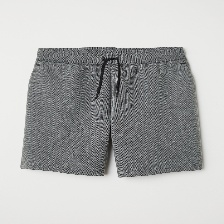

Product Title:  6773    Tom shorts (1)
Name: prod_name, dtype: object
Product Type:  6773    Shorts
Name: product_type_name, dtype: object
Product Graphical Appearance:  6773    Melange
Name: graphical_appearance_name, dtype: object

 ==================== Recommended products ====================


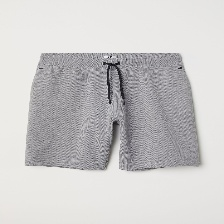

Product Title:  Tom shorts
Product Type:  Shorts
Product Graphical Appearance:  Melange
Cosine similarity score: 0.9687715


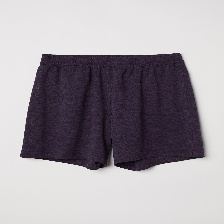

Product Title:  HAL SHORTS
Product Type:  Shorts
Product Graphical Appearance:  Melange
Cosine similarity score: 0.9536843


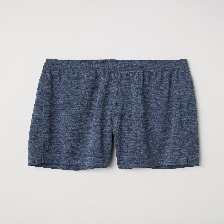

Product Title:  HAL SHORTS
Product Type:  Shorts
Product Graphical Appearance:  Melange
Cosine similarity score: 0.9534896


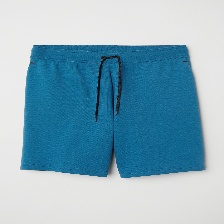

Product Title:  Tom shorts
Product Type:  Shorts
Product Graphical Appearance:  Solid
Cosine similarity score: 0.95304996


In [197]:
get_similar_products_cnn('0508640007', 5, "VGG16")


==================== input product details ====================


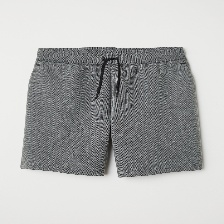

Product Title:  6773    Tom shorts (1)
Name: prod_name, dtype: object
Product Type:  6773    Shorts
Name: product_type_name, dtype: object
Product Graphical Appearance:  6773    Melange
Name: graphical_appearance_name, dtype: object

 ==================== Recommended products ====================


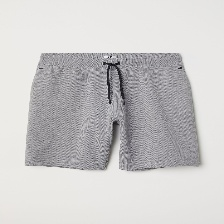

Product Title:  Tom shorts
Product Type:  Shorts
Product Graphical Appearance:  Melange
Cosine similarity score: 0.99867934


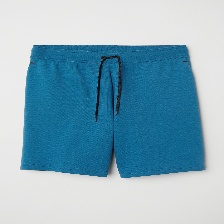

Product Title:  Tom shorts
Product Type:  Shorts
Product Graphical Appearance:  Solid
Cosine similarity score: 0.9986192


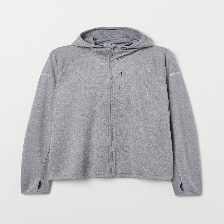

Product Title:  Roman running hood
Product Type:  Hoodie
Product Graphical Appearance:  Melange
Cosine similarity score: 0.99730575


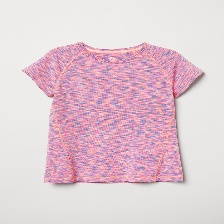

Product Title:  KATE TEE
Product Type:  T-shirt
Product Graphical Appearance:  Melange
Cosine similarity score: 0.9972657


In [198]:
get_similar_products_cnn('0508640007', 5, "ResNet50")

/Users/giangnguyen/Library/Python/3.10/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/giangnguyen/Library/Python/3.10/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/giangnguyen/Library/Python/3.10/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/giangnguyen/Library/Python/3.10/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t

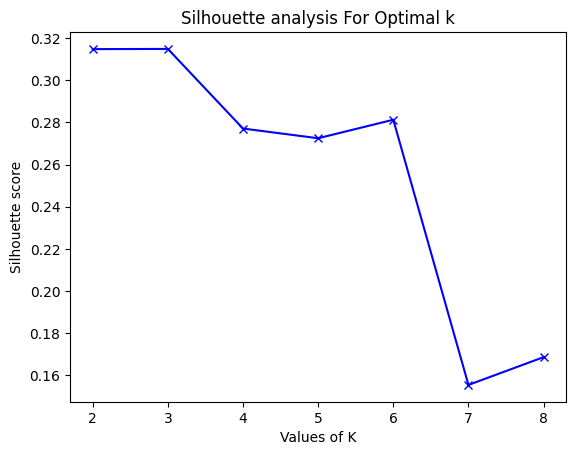

In [170]:
extracted_features, _ = get_extracted_features_resnet('0519975002')
Sum_of_squared_distances = []
silhouette_avg = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(extracted_features)
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(extracted_features, cluster_labels))
plt.plot(range_n_clusters,silhouette_avg,"bx-")
plt.xlabel("Values of K") 
plt.ylabel("Silhouette score") 
plt.title("Silhouette analysis For Optimal k")
plt.show()


In [173]:
from sklearn.cluster import KMeans


def get_similar_products_cnn_clustering(product_id, num_results):
    extracted_features, Productids = get_extracted_features_resnet(product_id)
    Productids = list(Productids)

    # fit kmeans model on extracted features
    kmeans = KMeans(n_clusters=6,
                    random_state=42).fit(extracted_features)

    # get the cluster index of the input product
    doc_id = Productids.index(product_id)
    input_product_cluster = kmeans.labels_[doc_id]

    # get the indices of the products in the same cluster as the input product
    indices = np.where(kmeans.labels_ == input_product_cluster)[0]

    print("="*20, "input product details", "="*20)
    ip_row = small_articles_df[small_articles_df['article_id'] == int(
        Productids[indices[0]])]

    img = Image.open("downscaled_images_structure/" +
                     ip_row['index_group_name'].values[0]+"/Images/" + "0"+str(ip_row["article_id"].values[0])+".jpg")
    display(img)

    print('Product Title: ', ip_row['prod_name'])
    print("\n", "="*20, "Recommended products", "="*20)
    counter = 0
    for i in range(1, len(indices)):
        rows = small_articles_df[small_articles_df['article_id'] == int(
            Productids[indices[i]])]
        for indx, row in rows.iterrows():
            if counter < num_results:
                img = Image.open("downscaled_images_structure/" +
                                 row['index_group_name'] +
                                 "/Images/0" + str(row["article_id"])+".jpg")
                display(img)
                print('Product Title: ', row['prod_name'])
                counter += 1
            else:
                break


/Users/giangnguyen/Library/Python/3.10/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


==================== input product details ====================


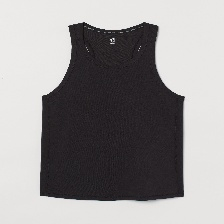

Product Title:  1607    Miami tanktop
Name: prod_name, dtype: object

 ==================== Recommended products ====================


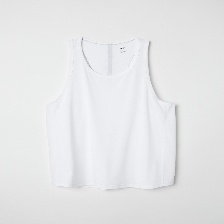

Product Title:  Miami tanktop


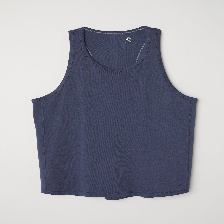

Product Title:  Miami tanktop


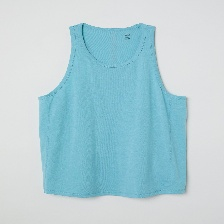

Product Title:  Miami tanktop


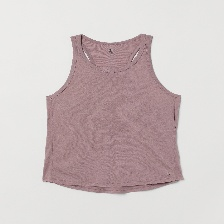

Product Title:  Miami tanktop


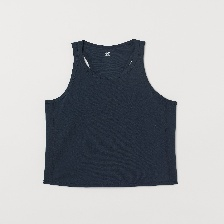

Product Title:  Miami tanktop


In [175]:
get_similar_products_cnn_clustering('0498740011', 5)
